In [57]:
%matplotlib inline

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


dir = '004349043'
# file = dir + "/kplr004349043-2009259160929_llc.fits.flare"
# filefake = "004349043/kplr004349043-2009259160929_llc.fits.fake"

# df = pd.read_table(file, comment="#", delimiter=",", 
#                    names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
#                           "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
#                           "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i"))

# dffake = pd.read_table(filefake, comment="#", delimiter=",", 
#                    names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
#                           "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
#                           "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i"))


Number of files: 17


/Users/scoggim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


(0.02, 3.0)

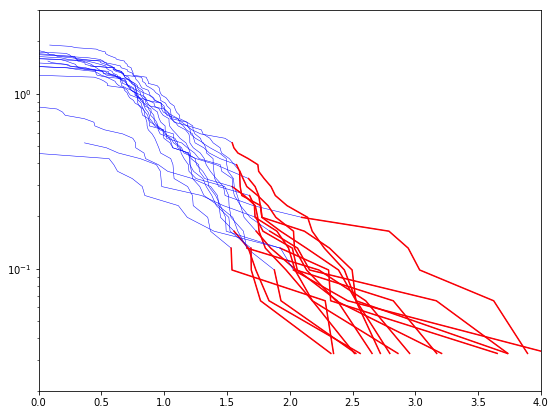

In [58]:
glob(dir+"/*.flare")
files = glob(dir+"/*.flare")

names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

print("Number of files: " + str(len(files)))
EPOINT = 0 # but, actually it should be like 34.5 or something

#set up color scheme
plt.figure(figsize=(9,7))

for x in range(len(files)):
    
    TotDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0]
    df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
    energy = df['Equiv_Dur']
    sort = np.argsort(energy)

    ffd_xEnergy = np.log10(energy[sort][::-1]) #+ EPOINT
    ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur


    plt.plot(ffd_xEnergy, ffd_yFrequency, lw = .5, c = 'blue')
    ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i']))#add Epoint

    plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = 'red')
    
plt.yscale('log')
plt.xlim(0,4)
plt.ylim(2e-2, 3e0)



In [55]:
#two values from each file, mean of tstart, ffd_y associated with a fixed energy ffd_x. pick an x value and for every file
#report the corresponding y value and then plot the avg start time against the y value.

#hints: use np.interp to get the FFD_Y value that exactly corresponds to a specific FFD_X

['004349043/kplr004349043-2009166043257_llc.fits.flare',
 '004349043/kplr004349043-2009259160929_llc.fits.flare',
 '004349043/kplr004349043-2009350155506_llc.fits.flare',
 '004349043/kplr004349043-2010078095331_llc.fits.flare',
 '004349043/kplr004349043-2010174085026_llc.fits.flare',
 '004349043/kplr004349043-2010265121752_llc.fits.flare',
 '004349043/kplr004349043-2010355172524_llc.fits.flare',
 '004349043/kplr004349043-2011073133259_llc.fits.flare',
 '004349043/kplr004349043-2011177032512_llc.fits.flare',
 '004349043/kplr004349043-2011271113734_llc.fits.flare',
 '004349043/kplr004349043-2012004120508_llc.fits.flare',
 '004349043/kplr004349043-2012088054726_llc.fits.flare',
 '004349043/kplr004349043-2012179063303_llc.fits.flare',
 '004349043/kplr004349043-2012277125453_llc.fits.flare',
 '004349043/kplr004349043-2013011073258_llc.fits.flare',
 '004349043/kplr004349043-2013098041711_llc.fits.flare',
 '004349043/kplr004349043-2013131215648_llc.fits.flare']

/Users/scoggim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


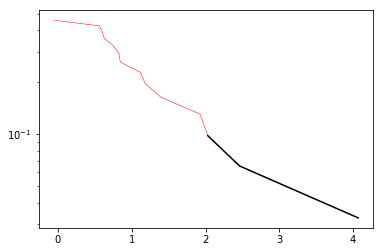

In [59]:
#11/8/2017

EPOINT = 0 # but, actually it should be like 34.5 or something
toteDur = 30.562777777 #this should be extracted from the .flare file FUTURE

energy = df['Equiv_Dur']
sort = np.argsort(energy)

ffd_xEnergy = np.log10(energy[sort][::-1]) #+ EPOINT
ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur


plt.plot(ffd_xEnergy, ffd_yFrequency, lw = .5, c = 'red')
ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i']))#add Epoint

plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = 'black')

plt.yscale('log')



0     0.000846
1     0.008429
2     0.007241
3     0.002252
4     0.001916
5     0.003280
6     0.003465
7     0.009742
8     0.005020
9     0.007153
10    0.004380
11    0.002528
12    0.024526
13    0.004001
14    0.009893
15    0.002591
16    0.007989
17    0.005834
18    0.003270
19    0.010102
20    0.024649
21    0.002400
22    0.001468
23    0.003391
24    0.003891
25   -0.000686
26    0.000876
27    0.001270
28    0.003534
29    0.002459
30    0.003213
31    0.011095
32    0.003989
33    0.002049
34    0.001960
35    0.009645
36    0.001641
37    0.003095
38    0.002453
39    0.004146
40    0.004437
41    0.002472
42    0.007034
43    0.007104
44    0.003865
45    0.003524
46    0.021694
47    0.004003
48    0.003115
49    0.003562
50    0.004302
51    0.002385
52    0.002886
53    0.004501
54    0.005268
55    0.006728
56    0.001643
57    0.028650
Name: amplitude, dtype: float64
[0.024526232210800001, 0.02464894913, 0.0216943806404, 0.028650384764499999]


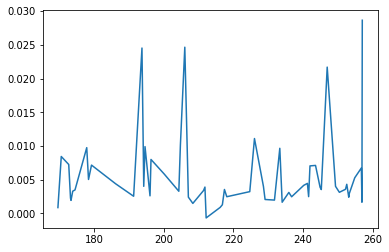

In [7]:
#11/7/2017
entryNum= df['amplitude'].size
ampSum = 0
flareArray=[]
for x in range (entryNum):
    ampSum = ampSum + (df['amplitude'][x])

#averageE = (sum/entryNum)
averageE = .015

for x in range (entryNum):
    if (df['amplitude'][x]) > averageE:
        flareArray.append(df['amplitude'][x])
print(df['amplitude'])
print(flareArray)
plt.plot(df['t_start'], df['amplitude'])


# Nflare = df['amplitude'].size
# energy = 10**np.random.random(Nflare)
# sort = np.argsort(energy)
# # energy[sort]
# ffd_xEnergy = np.log10(energy[sort][::-1])
# ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))

# #DO THIS
# plt.plot(ffd_xEnergy, ffd_yFrequency)
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('log Flare Energy')
# plt.ylabel('Cumulative Flare Frequency - #/day')
# plt.xlim(.1,1)

In [61]:
#some misc examples

#y = np.arange(50,100,1) ** 2
#plt.plot(y, np.cumsum(y))

x = np.arange(50, 100, 1)
print(x[::-1]) # how to quickly reverse an array, very pythonic

#plt.plot(np.cumsum(x)/sum(x), label='x')
#plt.plot(np.cumsum(y)/sum(y), label='y')
#plt.legend()

# a reverse cumulative distribution
#plt.plot(x[::-1], np.cumsum(x[::-1]) / sum(x))

#plt.plot(df['t_start'], df['amplitude'])

# event = np.arange(0, len(x), 1)
# print(event)
# plt.plot(x[::-1], event)
# plt.plot(x[::-1], np.cumsum(event), '-o' )
# plt.yscale('log')
# plt.xscale('log')


[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75
 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50]
